In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from skimage import feature,img_as_ubyte,img_as_bool,morphology,io,measure
import cv2
from skimage.color import rgb2gray
import warnings
from skimage.segmentation import clear_border
from skimage.filters import threshold_li
warnings.filterwarnings('ignore')
import time

In [2]:
#Funkcja pozwalająca wyświetlać łatwo nasz obraz w wybranej mapie kolorów
def showImg(im, title=None,colormap="gray", **kwargs):
    if 'cmap' not in kwargs:
        kwargs['cmap'] = colormap
    plt.figure(figsize=(15,10))
    plt.imshow(im, interpolation='none', **kwargs)
    if title:
        plt.title(title)
    plt.axis('off')
    
#Funkcja pozwalająca wyświetlać dwa obrazy obok siebie
def show2imgs(im1, im2, title1='Obraz pierwszy', title2='Obraz drugi', size=(15,10)):   
    f, (ax1, ax2) = plt.subplots(1,2, figsize=size)
    ax1.imshow(im1, cmap='gray')
    ax1.axis('off')
    ax1.set_title(title1)

    ax2.imshow(im2, cmap='gray')
    ax2.axis('off')
    ax2.set_title(title2)
    plt.show()

In [3]:
#Funkcja sprawdzająca czy nie opuściliśmy obszaru obrazu
def stillImage(image, x=0, y=0):
    if x>=0 and x < image.shape[0] and y >= 0 and y < image.shape[1]:
        return True
    else:
        return False

#Funkcja indeksująca piksele należące do obiektu
def indexImg(i,j,image,color):
    q = [(i,j)]
    while q:
        ii,jj = q.pop(0)
        for dx in range(-1,2):
            for dy in range(-1,2):
                if dx == 0 and dy == 0:
                    continue
                a = ii + dx
                b = jj + dy
                if stillImage(image, a, b) and image[a][b] == 255:
                    image[a][b] = color
                    q.append((a,b))


#Funkcja segmentująca (gdy odnajdzie piksel należący do obiektu wywoła funkcje indeksującą)           
def segmentImg(image):
    segment_table = image.copy()
    cnt = 1
    x = 0
    for i in range(segment_table.shape[0]):
        for j in range(segment_table.shape[1]):
            if segment_table[i][j] == 255:
                x += 1
                segment_table[i][j] = cnt
                indexImg(i,j,segment_table,cnt)
                cnt += 1

                
    return x,segment_table

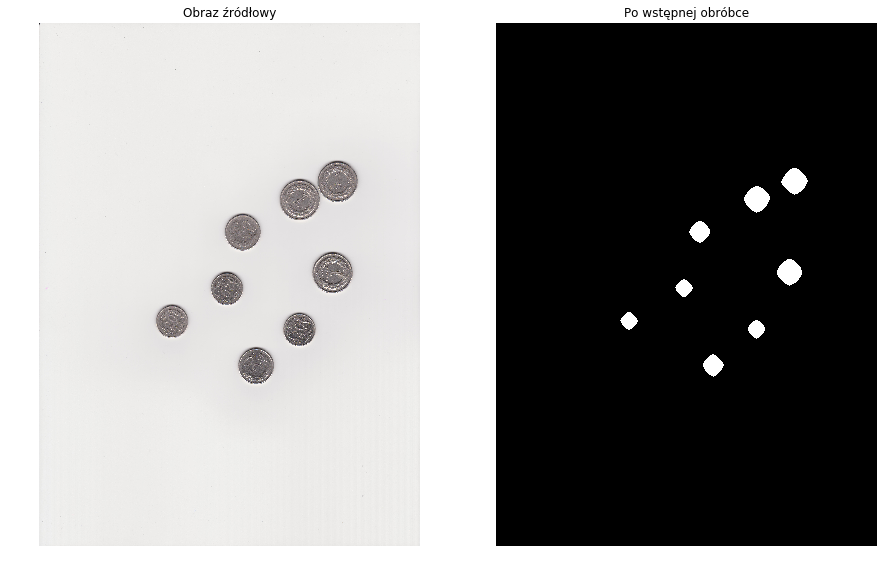

In [4]:
def pretreatment(image):
    #Kopia by nie utracić obrazu oryginalnego
    im=image.copy()
    #Konwersja do greyscale oraz zamiana typu na ubyte [0-255] 8bit
    im = img_as_ubyte(rgb2gray(im))
    #Filtr dolnoprzepustowy aby poprawić obraz (niwelujemy różnice w jasności)
    im = cv2.blur(im, (7,7))
    #Ustalenie progu binaryzacji
    th = threshold_li(im)
    #Binaryzacja LI naszego obrazu greyscale
    th, im = cv2.threshold(im, th, 255, cv2.THRESH_BINARY_INV)
    #Ustalamy element strukturalny
    element = np.ones((11,11),np.uint8)
    #Morfologiczne zamknięcie na obrazie binarnym
    im = cv2.morphologyEx(im, op=cv2.MORPH_CLOSE, kernel=element, iterations=2)
    #Ustalamy element strukturalny
    morphKernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (21,21))
    #Wykrywamy krawędzie filtrem Canny'ego
    edgeIm = cv2.Canny(im, 50, 120)
    #Przeprowadzamy operacje zamknięcia na wyniku filtru Canny'ego
    edgeIm = cv2.morphologyEx(edgeIm, op=cv2.MORPH_CLOSE, kernel=morphKernel, iterations=17)
    #Negujemy nasz wynik (każdy z elementów tablicy) by otrzymać tablice przeciwną
    invEdgeIm = cv2.bitwise_not(edgeIm.copy())
    #Przeprowadzamy koniunkcje dwóch tablic dla każdego elementu
    im = np.bitwise_and(im, invEdgeIm)
    #Ustalamy jądro dla erozji
    kernel = np.ones((17,17),np.uint8)
    #Erodujemy obraz by rozdzielić obiekty
    im = cv2.erode(im, kernel=kernel, iterations=10)
    
    return im

#Wczytujemy interesujący nas obraz [068-082]
source = io.imread("069.jpg")
#Dokonujemy jego wstępnej obróbki
imageBin=pretreatment(source)
show2imgs(source,imageBin,"Obraz źródłowy","Po wstępnej obróbce")

In [5]:
#Liczmy czas naszej segmentacji (zazwyczaj [90-200]sekund)
start_time = time.time()
#Przeprowadzamy segmentacje z indeksacją
_, segment_table = segmentImg(imageBin)
elapsed_time  = time.time() - start_time
print("Segmentacja ukończona w {:.5} sekund".format(elapsed_time))


Segmentacja ukończona w 95.254 sekund


Obiektów jest 8 i zajmują około 1.344% obrazu


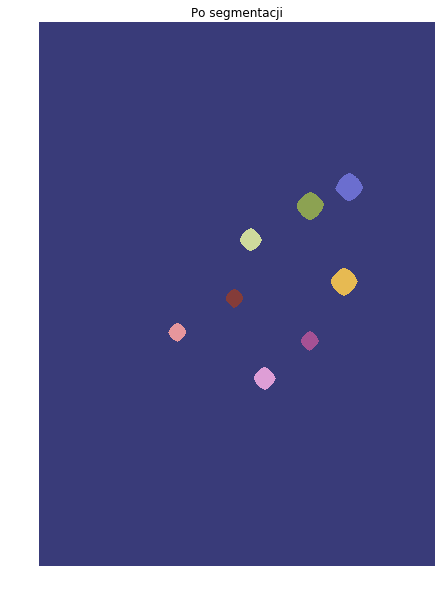

In [6]:
showImg(segment_table,"Po segmentacji","tab20b")

#tworzmy tablice z unikalnymi posortowanymi obiektami (indeksami i iliością pikseli)
objectArray=np.unique(segment_table, return_counts=True)


#Tworzymy słownik łącząc numer obiektu(index) z ilością pikseli mu odpowiadającą
objectDictionary=dict(zip(objectArray[0][1:],objectArray[1][1:]))
#Zaczynamy od 1 gdyż na miejscu 0 mamy liczbe wszystkich pikseli w obrazie


#Liczmy ile na obrazie procentowo zajmują nasze obiekty
percentage=100*sum(objectArray[1][1:])/objectArray[1][0]
print("Obiektów jest {} i zajmują około {:.4}% obrazu".format(objectArray[0][-1],percentage))

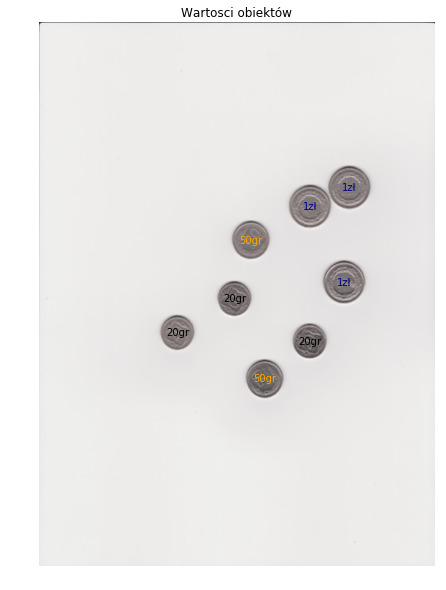

In [10]:
imageWithValues=source.copy()
regions=measure.regionprops(segment_table)

#Blur ze względu na czytelność danych wyjściowych
imageWithValues=cv2.blur(imageWithValues, (21,21))
showImg(imageWithValues,"Wartosci obiektów")

#Przygotowanie zmiennych potrzebnych do liczenia kwoty na obrazie
coins500 = 0
coins200 = 0
coins100 = 0
coins50 = 0
coins20 = 0
coins10 = 0
coins5 = 0
coins2 = 0
coins1 = 0


#Dla każdego z naszych indeksowanych obiektów nanosimy odpowiedni napis zależnie od jego ilości pikseli
#dodatkowo zwiększamy licznik monet danego typu jeśli wystąpiły
for region in regions:
    x, y = region.centroid
    area = region.area
    areaValue = str(int(area/100))
    coinColor="pink"

    if area>80000 and area <90000:
        areaValue="1zł"
        coinColor="darkblue"
        coins100+=1
    elif area>90000:
        areaValue="5zł"
        coinColor="indigo"
        coins500+=1
    elif area>65000 and area<80000:
        areaValue="2zł"
        coinColor="gold"
        coins200+=1
    elif area>50000 and area<65000:
        areaValue="50gr"
        coinColor="orange"
        coins50+=1
    elif area>36000 and area<45000:
        areaValue="20gr"
        coinColor="black"
        coins20+=1
    elif area>20000 and area<30000:
        areaValue="10gr"
        coinColor="white"
        coins10+=1
    elif area>45000 and area<50000:
        areaValue="5gr"
        coinColor="yellow"
        coins5+=1
    elif area>30000 and area<36000:
        areaValue="2gr"
        coinColor="purple"
        coins2+=1
    elif area>5000 and area<20000:
        areaValue="1gr"
        coinColor="red"
        coins1+=1
    #Wyświetlamy nasze wyniki w środku monet
    plt.text(y, x, areaValue, color=coinColor, ha='center', va='center')
    
    

In [11]:
#Wyświetlamy dane wyjściowe o ilości monet danego typu
print("Wszystkich monet:",objectArray[0][-1])
print('monet 5zł jest:', coins500)
print('monet 2zł jest:', coins200)
print('monet 1zł jest:', coins100)
print('monet 50gr jest:', coins50)
print('monet 20gr jest:', coins20)
print('monet 10gr jest:', coins10)
print('monet 5gr jest:', coins5)
print('monet 2gr jest:', coins2)
print('monet 1gr jest:', coins1)

#Liczmy kwote na obrazie
changeZL=5*coins500+2*coins200+coins100
changeGR=50*coins50+20*coins20+10*coins10+5*coins5+2*coins2+coins1
if int(changeGR/100)>0:
    changeZL+=int(changeGR/100)
    changeGR=changeGR%100

print("\n\nNa obrazie jest: {0}zł {1}gr".format(changeZL,changeGR))

Wszystkich monet: 8
monet 5zł jest: 0
monet 2zł jest: 0
monet 1zł jest: 3
monet 50gr jest: 2
monet 20gr jest: 3
monet 10gr jest: 0
monet 5gr jest: 0
monet 2gr jest: 0
monet 1gr jest: 0


Na obrazie jest: 4zł 60gr


In [12]:
from scipy import ndimage as ndi
label_objects, nb_labels = ndi.label(imageBin)
from scipy.spatial import distance
import math


#Funkcja obliczająca liczbe pikseli należących do obiektu
def getFigure(labelledImage, objNumber):
    
    points = []
    for y in range(labelledImage.shape[0]):
        for x in range(labelledImage.shape[1]):
            if labelledImage[y,x] == objNumber:
                points.append((y,x))

    return points



#Funkcja obliczająca koordynaty środka ciężkości obiektu
def cog2(points):
    mx=0
    my=0
    for (y,x) in points:
        mx = mx + x
        my = my + y
    mx = mx/len(points)
    my = my/len(points)
    
    return [my, mx]



#Funkcja obliczająca współczynnik Blaira-Blissa
def computeBB(points):
    
    s = len(points)
    my,mx = cog2(pts)
    
    r = 0
    for point in points:
         r = r + distance.euclidean(point,(my,mx))**2
            
    return s/(math.sqrt(2*math.pi*r))


#Funkcja obliczająca współczynnik Fereta
def computeFeret(points):
    
    px = [x for (y,x) in points]
    py = [y for (y,x) in points]
    
    fx = max(px) - min(px)
    fy = max(py) - min(py)
    
    return float(fy)/float(fx)    



#Wypisanie danych
for i in range(nb_labels):
    pts = getFigure(label_objects, i+1)
    bb = computeBB(pts)
    feret = computeFeret(pts)
    
    print('Liczba punktow: ',len(pts),'\nSrodek ciezkosci: ', cog2(pts),'\nBlair-Bliss: ', bb,'\nFeret: ',feret, '\n---\n')

Liczba punktow:  84138 
Srodek ciezkosci:  [2130.1794670660106, 3996.6355511184006] 
Blair-Bliss:  0.9952060271375252 
Feret:  1.019718309859155 
---

Liczba punktow:  84648 
Srodek ciezkosci:  [2371.593646630753, 3491.9734784046877] 
Blair-Bliss:  0.9961023987542256 
Feret:  1.0257879656160458 
---

Liczba punktow:  55385 
Srodek ciezkosci:  [2806.1926333844904, 2727.4435496975716] 
Blair-Bliss:  0.9949097751300853 
Feret:  1.034965034965035 
---

Liczba punktow:  83090 
Srodek ciezkosci:  [3348.6196052473224, 3928.7392104946443] 
Blair-Bliss:  0.9958330067906686 
Feret:  1.0433526011560694 
---

Liczba punktow:  37020 
Srodek ciezkosci:  [3561.561993517018, 2516.4544300378175] 
Blair-Bliss:  0.9924090430713712 
Feret:  1.0683760683760684 
---

Liczba punktow:  37007 
Srodek ciezkosci:  [3999.758018753209, 1781.4345394114628] 
Blair-Bliss:  0.9936151512147436 
Feret:  1.0468085106382978 
---

Liczba punktow:  38067 
Srodek ciezkosci:  [4110.8922426248455, 3486.131715133843] 
Blair-Bli

In [13]:
#Funkcja obliczająca współczynnik Haralicka
def computeHaralick(centroid, contours):
    n = len(contours)
    mx, my = centroid
    d1 = 0
    d2 = 0
    for i in range(n):
        d1 += distance.euclidean((contours[i][0][1], contours[i][0][0]),(my,mx))
        d2 += (distance.euclidean((contours[i][0][1], contours[i][0][0]),(my,mx))**2 - 1)
    return math.sqrt((d1**2)/(n*d2))

#Tworzenie odpowiedniego słownika aby otrzymać centroid
data=[]
for key in objectDictionary.keys():
    _, contours, hier = cv2.findContours(np.uint8(segment_table==key), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    for c in contours:
        M = cv2.moments(c)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        data.append({'id':key, 'centroid': (cX, cY), 'contours':c, 'area': objectDictionary[key]})
    
    
for obj in data:
    points = getFigure(segment_table, obj["id"])
    centroid = obj["centroid"]
    har=computeHaralick(centroid,obj["contours"])

    print('Numer obiektu: {}\nHaralick: {}\n---\n'.format(obj["id"],har))

Numer obiektu: 1
Haralick: 0.9988057721673862
---

Numer obiektu: 2
Haralick: 0.9990336912165707
---

Numer obiektu: 3
Haralick: 0.9987447504430518
---

Numer obiektu: 4
Haralick: 0.9989648777566619
---

Numer obiektu: 5
Haralick: 0.998098892373691
---

Numer obiektu: 6
Haralick: 0.9984200237474146
---

Numer obiektu: 7
Haralick: 0.9982991582214675
---

Numer obiektu: 8
Haralick: 0.9986103125869743
---



In [ ]:
print(data[0]['id'])
print(data[0]['centroid'])
print(data[1]['id'])
print(data[1]['centroid'])
print(data[-1]['id'])
print(data[-1]['centroid'])